Estimated Homography Matrix:
 [[-8.53593793e-02 -1.50193313e+00  1.43093144e+02]
 [ 6.26459074e-03 -2.18550758e+00  1.76067303e+02]
 [-2.36917398e-04 -1.14763460e-02  1.00000000e+00]]


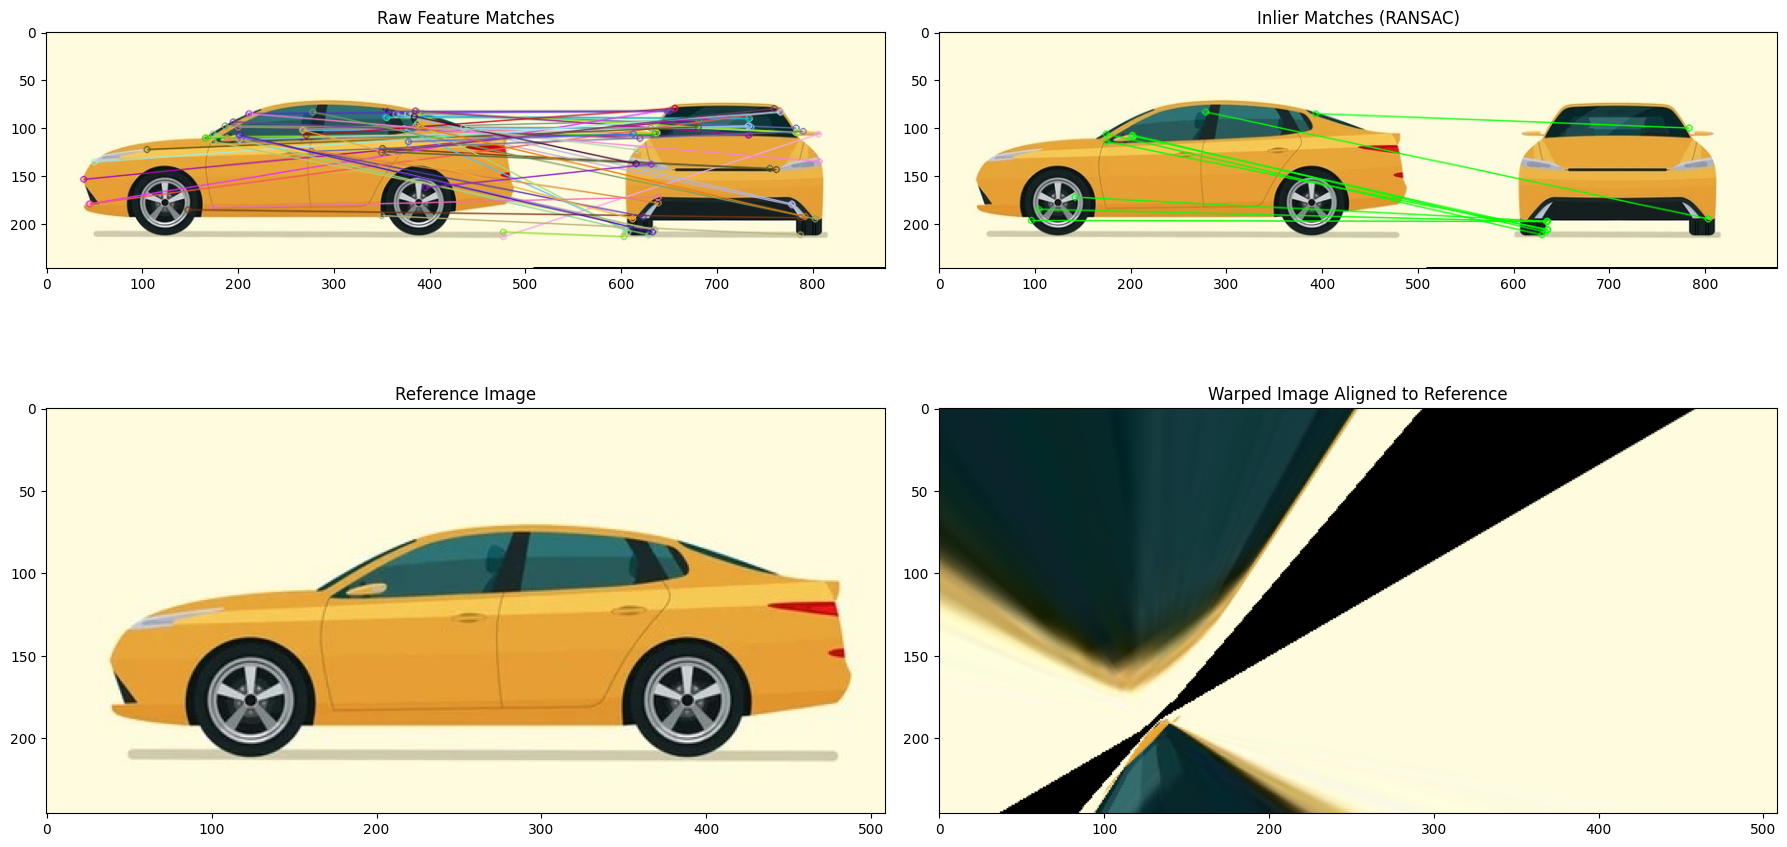

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load images ---
img1 = cv2.imread("/content/cv pictures 2.jpg")  # Reference image (poster/book cover)
img2 = cv2.imread("/content/cv pictures.jpg")  # Transformed image (different viewpoint)

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# --- Detect and extract features using ORB (or SIFT if available) ---
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# --- Match keypoints using BFMatcher with Hamming distance ---
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw raw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

# --- Extract matched points ---
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# --- Estimate Homography using RANSAC ---
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matches_mask = mask.ravel().tolist()

print("Estimated Homography Matrix:\n", H)

# Draw matches after RANSAC
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None,
                   matchesMask=matches_mask, flags=2)
img_inlier_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

# --- Warp one image to align with the other ---
h, w, _ = img1.shape
img_warped = cv2.warpPerspective(img2, H, (w, h))

# --- Visualization ---
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.title("Raw Feature Matches")
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 2)
plt.title("Inlier Matches (RANSAC)")
plt.imshow(cv2.cvtColor(img_inlier_matches, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 3)
plt.title("Reference Image")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 4)
plt.title("Warped Image Aligned to Reference")
plt.imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()
